The following example shows how to train a model. Get a list of training data csv file in the selected folder. Lessons learned so far:
- Training result is very sensitive to normalization. The normalization approach based on mean and variance does not work very well. Still need to manually set mean and variance.
- t-sne plot of adapter trace is an important flag of training result. 
- h net does not have to descent because phi net training strives to make it rise, while h net training itself tries to lower the loss
- Increase the h training frequency to fight against rising h 
- Increase alpha to push domain info to adapter
- Increase number of features to minimize MSE loss.
- ocassional small spike in cross entropy loss is possibly a sign that phi net become further domain invariant and may not be bad.
- at the late stage of training while both mse loss and cross entropy loss converge. May need to train h net every step to refine the optimization direction.
- Do not need to select the model at the end epoch. Select the epoch when the loss is reasonably low and stable. 
- RMS is a good indicator because it matches the least square form of loss function
- When the residual force is small, e.g. training disturbance force compensated by BEMT, disturbance normalization should scale up the label for better learning. 

Existing problem:
- The more classes, the harder to train. The difficulty comes from instability of loss_f and loss_c. alpha is hard to tune.
- t-sne gets worse as epoch grows and the cross entropy loss remains the same. 

In [1]:
import os
import matplotlib.pyplot as plt

import training_manager

current_dir = os.getcwd()
# training_subfolder = "wind_near_wall_wo_bemt_in_control_train_x_only_wind"
# training_subfolder = "wind_near_wall_wo_bemt_in_control_train_z_only_wind"
training_subfolder = "wind_near_wall_wo_bemt_in_control_train_xz_wind"
# training_subfolder = "nf_training_back2back"
# validation_subfolder = "nf_validation_back2back"
validation_subfolder = "wind_near_wall_validation_no_bemt"

def generate_data_list(subfolder):
    """
    Generate a list of data files in the specified subfolder.
    """
    folder_path = os.path.join(os.path.dirname(current_dir), "data", "training", subfolder)
    file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

    # Filter out files that do not end with .csv
    file_names = [f for f in file_names if f.endswith('.csv')]
    # add subfolder to the file names
    data_list = [os.path.join(subfolder, f) for f in file_names]
    return data_list

data_list = generate_data_list(training_subfolder)
print("Training Data List:")
for data in data_list:
    print(data)

validation_list = generate_data_list(validation_subfolder)
print("\nValidation Data List:")
for data in validation_list:
    print(data)

path1 = os.path.join(training_subfolder, "input_label_map_disturbance_force_label.yaml")
path2 = os.path.join(training_subfolder, "column_map.yaml")

Training Data List:
wind_near_wall_wo_bemt_in_control_train_xz_wind\test_wind_near_wall_x0_0_y0_0_z0_0_d0_5_train_no_bemt.csv
wind_near_wall_wo_bemt_in_control_train_xz_wind\test_wind_near_wall_x0_0_y0_0_z3_0_d0_5_train_no_bemt.csv
wind_near_wall_wo_bemt_in_control_train_xz_wind\test_wind_near_wall_x0_0_y0_0_z5_0_d0_5_train_no_bemt.csv
wind_near_wall_wo_bemt_in_control_train_xz_wind\test_wind_near_wall_x0_0_y0_0_zn3_0_d0_5_train_no_bemt.csv
wind_near_wall_wo_bemt_in_control_train_xz_wind\test_wind_near_wall_x0_0_y0_0_zn5_0_d0_5_train_no_bemt.csv
wind_near_wall_wo_bemt_in_control_train_xz_wind\test_wind_near_wall_xn1_0_y0_0_z0_0_d0_5_train_no_bemt.csv
wind_near_wall_wo_bemt_in_control_train_xz_wind\test_wind_near_wall_xn1_0_y0_0_z3_0_d0_5_train_no_bemt.csv
wind_near_wall_wo_bemt_in_control_train_xz_wind\test_wind_near_wall_xn1_0_y0_0_z5_0_d0_5_train_no_bemt.csv
wind_near_wall_wo_bemt_in_control_train_xz_wind\test_wind_near_wall_xn1_0_y0_0_zn3_0_d0_5_train_no_bemt.csv
wind_near_wall_wo_b

- Make sure the input_label_map_disturbance_force_label.yaml is in the selected folder. This yaml defines which fields are model inputs and which fields are data labels. 
- Make sure the column_map.yaml is in the selected folder. This yaml maps data fields to the corresponding column in the csv files. This file can be auto-generated by `Simulation\simulation\training_data_user_guide.ipynb`
- If this is the first time to train on this data. The script will normalize the data and save the normalization parameters into a file.

Setting up data factory...
Loading normalization params file from
..\data\training\wind_near_wall_wo_bemt_in_control_train_xz_wind\normalization_params.yaml
Using 6001 samples from the dataset for training from source file: wind_near_wall_wo_bemt_in_control_train_xz_wind\test_wind_near_wall_x0_0_y0_0_z0_0_d0_5_train_no_bemt.csv
Using 6001 samples from the dataset for training from source file: wind_near_wall_wo_bemt_in_control_train_xz_wind\test_wind_near_wall_x0_0_y0_0_z3_0_d0_5_train_no_bemt.csv
Using 6001 samples from the dataset for training from source file: wind_near_wall_wo_bemt_in_control_train_xz_wind\test_wind_near_wall_x0_0_y0_0_z5_0_d0_5_train_no_bemt.csv
Using 6001 samples from the dataset for training from source file: wind_near_wall_wo_bemt_in_control_train_xz_wind\test_wind_near_wall_x0_0_y0_0_zn3_0_d0_5_train_no_bemt.csv
Using 6001 samples from the dataset for training from source file: wind_near_wall_wo_bemt_in_control_train_xz_wind\test_wind_near_wall_x0_0_y0_0_zn5_0

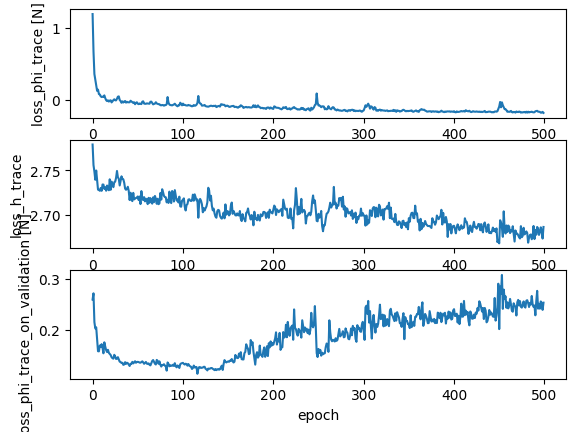

In [2]:
# use the data from previous section to train the model

manager = training_manager.TrainingManager()
manager.set_up(
    data_menu=data_list,
    # data_menu=data_list[:4],    # use small data list for quick testing
    input_label_map_file=path1,
    column_map_file=path2,
    can_skip_io_normalizaiton=False,
    can_inspect_data=False,
    validation_data_menu=validation_list[-1:]
)
plt.show() 
manager.train()
manager.trainer_instance.plot_loss()

plt.show()  

Inspect data in the data list.

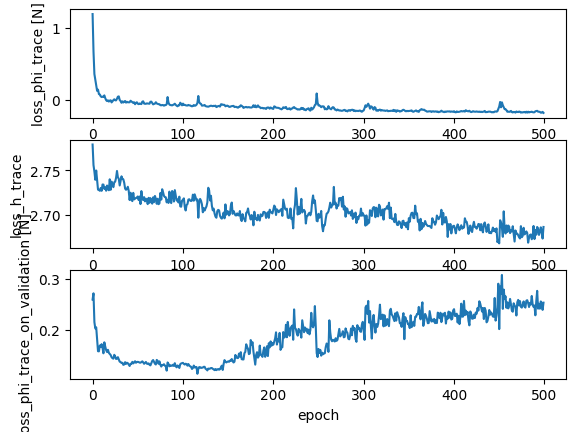

In [3]:
# trainer_instance.inspect_data(data_list[:2])
manager.trainer_instance.plot_loss()

Inspect t-sne of a_trace.

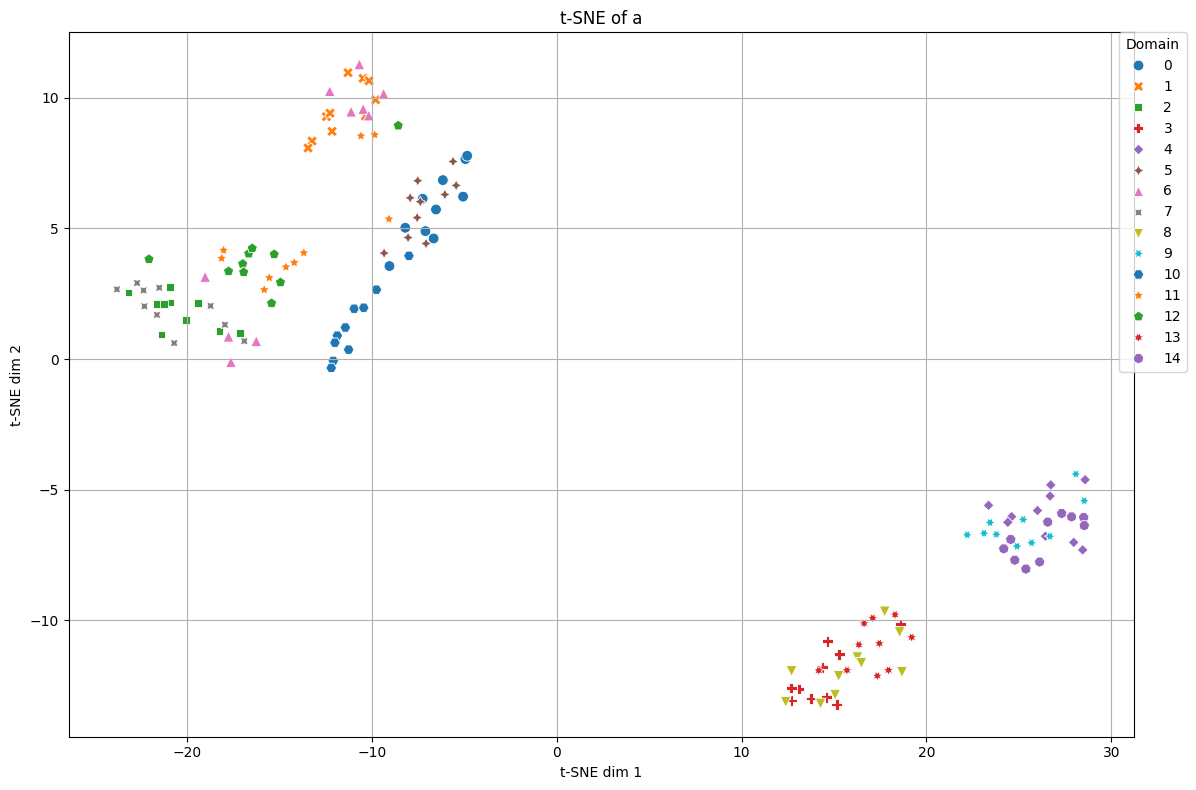

In [4]:
import performance_analyzer
can_print_3d = False
n = 100
performance_analyzer.plot_tsne_of_a(manager.trainer_instance.a_trace, list(range(n, n + 10)))
plt.show()  
if can_print_3d:
    %matplotlib tk
    performance_analyzer.plot_tsne_3d_of_a(manager.trainer_instance.a_trace, list(range(n, n + 10)))


After training, we can save the model in the following way.

In [5]:
model_name = training_subfolder
manager.save_model(model_name)

Model saved to model\wind_near_wall_wo_bemt_in_control_train_xz_wind.pth


Test the model using the test set.

test Data List:
wind_near_wall_validation_no_bemt\test_wind_near_wall_x0_0_y0_0_z10_0_d0_5_validation_no_bemt.csv
wind_near_wall_validation_no_bemt\test_wind_near_wall_x0_0_y0_0_z1_0_d0_5_validation_no_bemt.csv
wind_near_wall_validation_no_bemt\test_wind_near_wall_x0_0_y0_0_z4_0_d0_5_validation_no_bemt.csv
wind_near_wall_validation_no_bemt\test_wind_near_wall_x0_0_y0_0_zn10_0_d0_5_validation_no_bemt.csv
wind_near_wall_validation_no_bemt\test_wind_near_wall_x0_0_y0_0_zn1_0_d0_5_validation_no_bemt.csv
wind_near_wall_validation_no_bemt\test_wind_near_wall_x0_0_y0_0_zn4_0_d0_5_validation_no_bemt.csv
wind_near_wall_validation_no_bemt\test_wind_near_wall_xn2_0_y0_0_z10_0_d0_5_validation_no_bemt.csv
wind_near_wall_validation_no_bemt\test_wind_near_wall_xn2_0_y0_0_z1_0_d0_5_validation_no_bemt.csv
wind_near_wall_validation_no_bemt\test_wind_near_wall_xn2_0_y0_0_z4_0_d0_5_validation_no_bemt.csv
wind_near_wall_validation_no_bemt\test_wind_near_wall_xn2_0_y0_0_zn10_0_d0_5_validation_no_bemt.csv
wi

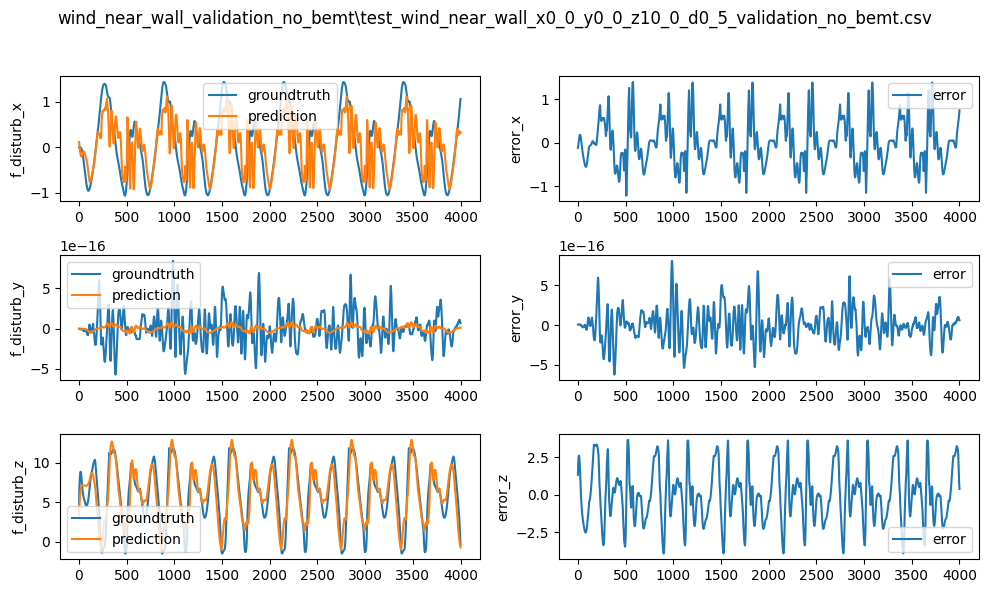

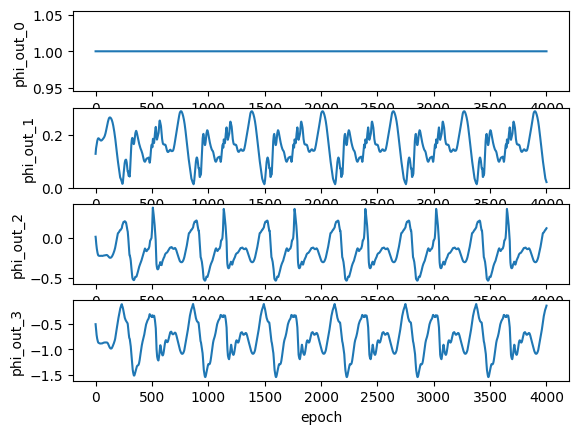

phi_out: tensor([[ 1.0000,  0.1282,  0.0166, -0.4997],
        [ 1.0000,  0.1300,  0.0143, -0.5067],
        [ 1.0000,  0.1318,  0.0121, -0.5129],
        ...,
        [ 1.0000,  0.0439,  0.1683, -0.2284],
        [ 1.0000,  0.0446,  0.1694, -0.2335],
        [ 1.0000,  0.0461,  0.1711, -0.2394]])
a = tensor([[-6.8050e-02,  1.0306e-19, -4.8204e+00],
        [-4.4808e+00, -1.4908e-17,  3.7711e+00],
        [ 7.7293e-01,  2.4825e-17,  5.8835e+00],
        [-1.2126e+00, -4.2858e-18, -9.0229e+00]])


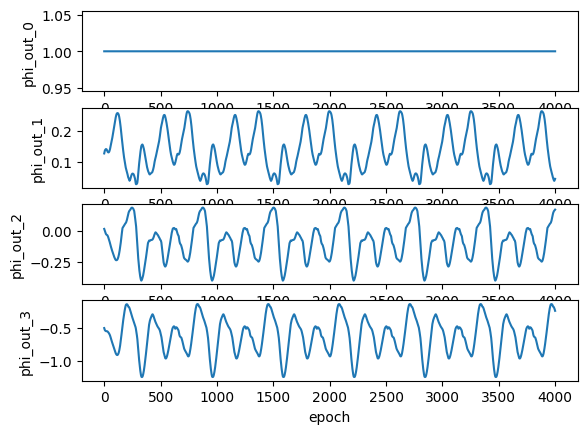

phi_out: tensor([[ 1.0000,  0.1283,  0.0163, -0.5005],
        [ 1.0000,  0.1314,  0.0123, -0.5122],
        [ 1.0000,  0.1344,  0.0082, -0.5240],
        ...,
        [ 1.0000,  0.0377,  0.1597, -0.2261],
        [ 1.0000,  0.0369,  0.1612, -0.2297],
        [ 1.0000,  0.0369,  0.1628, -0.2334]])
a = tensor([[-1.4266e-01, -4.5190e-18, -3.6220e+00],
        [-5.3146e+00, -1.8948e-17,  8.7324e+00],
        [ 1.6210e+00,  1.7522e-17,  2.1764e+00],
        [-1.6446e+00, -1.5587e-17, -8.2861e+00]])


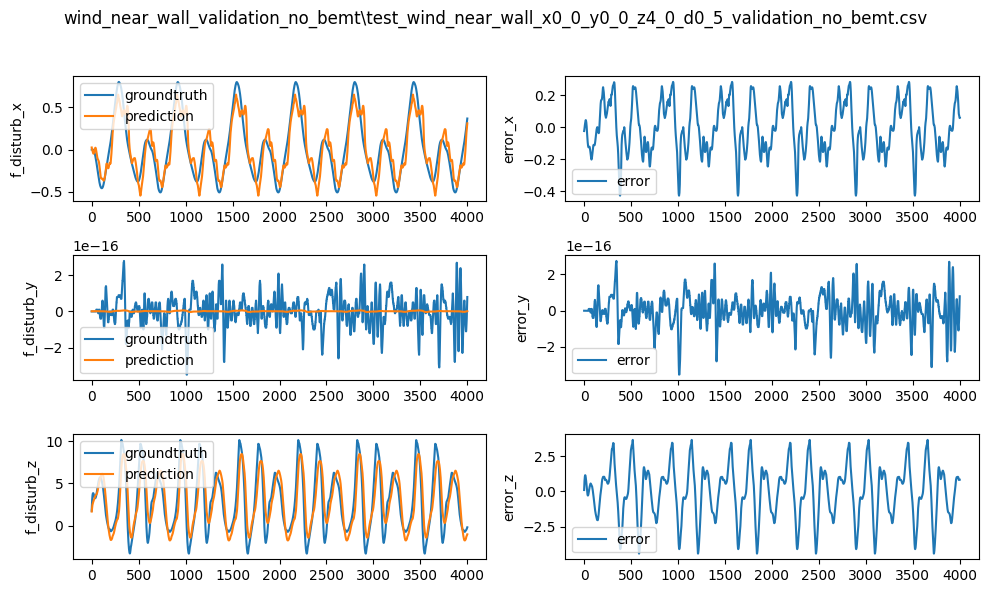

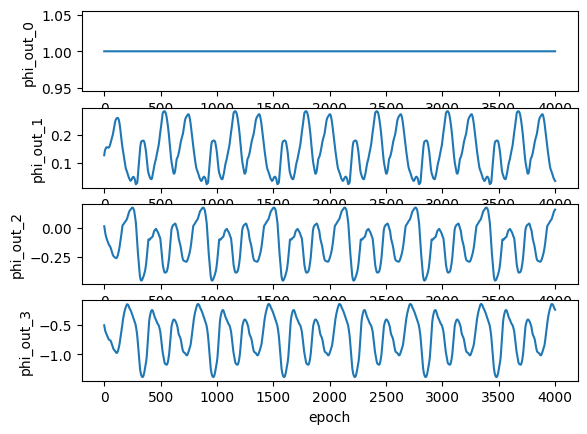

phi_out: tensor([[ 1.0000,  0.1290,  0.0150, -0.5030],
        [ 1.0000,  0.1362,  0.0035, -0.5336],
        [ 1.0000,  0.1430, -0.0172, -0.5710],
        ...,
        [ 1.0000,  0.0449,  0.1122, -0.2365],
        [ 1.0000,  0.0443,  0.1131, -0.2422],
        [ 1.0000,  0.0436,  0.1139, -0.2481]])
a = tensor([[ 6.2409e-01, -1.4037e-16,  4.0205e+00],
        [-9.3286e+00,  1.5362e-16,  4.3162e+00],
        [-4.9486e+00,  4.6582e-16, -1.7317e+00],
        [-3.6293e-02, -2.4610e-16,  2.4135e-02]])


phi_out: tensor([[ 1.0000,  0.1280,  0.0170, -0.4989],
        [ 1.0000,  0.1286,  0.0164, -0.5009],
        [ 1.0000,  0.1292,  0.0159, -0.5022],
        ...,
        [ 1.0000,  0.0420,  0.1677, -0.2259],
        [ 1.0000,  0.0428,  0.1689, -0.2309],
        [ 1.0000,  0.0435,  0.1701, -0.2356]])
a = tensor([[-3.6551e-02,  1.1188e-18, -4.0688e+00],
        [-4.7410e+00, -4.3121e-17,  1.1071e+00],
        [ 4.2857e-01,  1.8871e-17,  2.2930e+00],
        [-1.1626e+00, -5.7826e-18, -6.7123e+00]])


phi_out: tensor([[ 1.0000,  0.1281,  0.0168, -0.4994],
        [ 1.0000,  0.1294,  0.0152, -0.5042],
        [ 1.0000,  0.1307,  0.0138, -0.5084],
        ...,
        [ 1.0000,  0.0393,  0.1602, -0.2261],
        [ 1.0000,  0.0384,  0.1618, -0.2291],
        [ 1.0000,  0.0375,  0.1634, -0.2320]])
a = tensor([[ 9.6248e-02,  3.6694e-17, -2.0940e+00],
        [-6.3534e+00,  8.7465e-17,  2.1240e+00],
        [-5.2045e-01, -9.1413e-17,  2.1862e+00],
        [-1.1519e+00,  8.9621e-17, -3.7104e+00]])


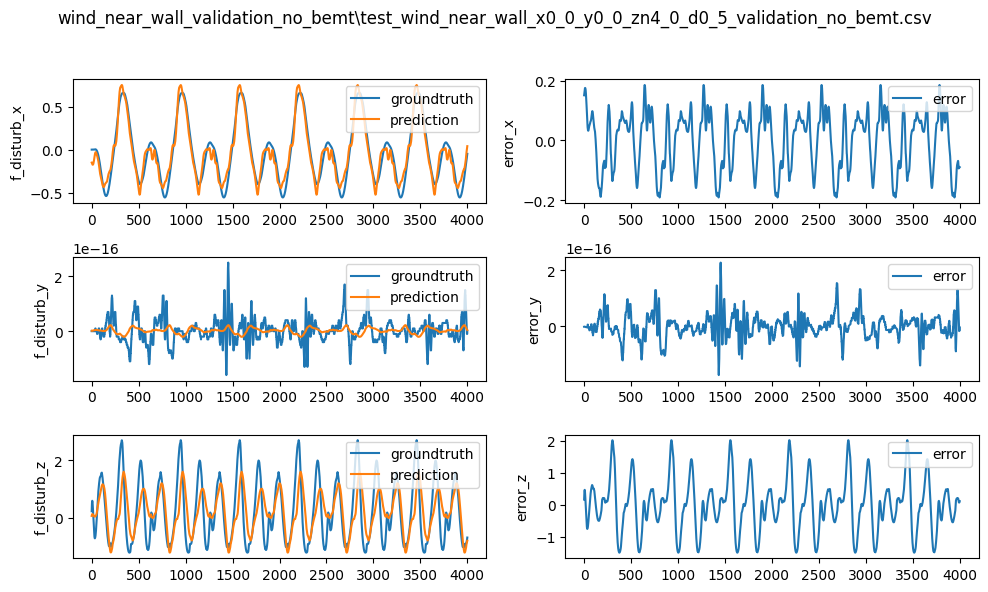

phi_out: tensor([[ 1.0000,  0.1287,  0.0157, -0.5019],
        [ 1.0000,  0.1345,  0.0078, -0.5225],
        [ 1.0000,  0.1405, -0.0079, -0.5497],
        ...,
        [ 1.0000,  0.0316,  0.1067, -0.1929],
        [ 1.0000,  0.0306,  0.1092, -0.1891],
        [ 1.0000,  0.0295,  0.1115, -0.1853]])
a = tensor([[-6.4370e-01,  9.7686e-17, -2.1837e+00],
        [-9.5418e+00, -4.6469e-16,  4.4521e+00],
        [ 3.3075e+00, -5.0845e-17,  2.9745e+00],
        [-2.9269e+00,  1.0222e-16, -1.0401e+01]])


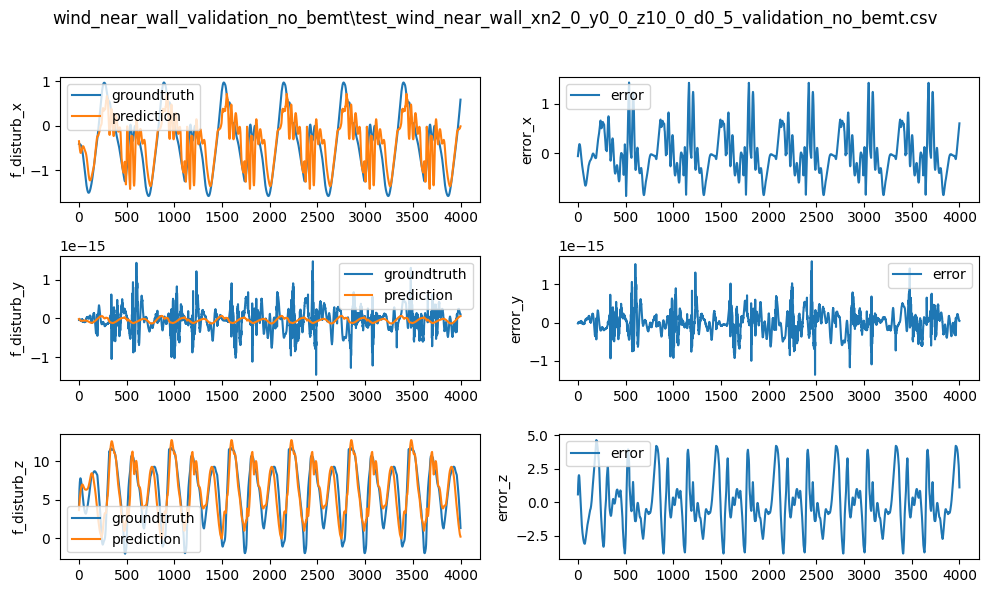

phi_out: tensor([[ 1.0000,  0.1281,  0.0167, -0.4996],
        [ 1.0000,  0.1302,  0.0149, -0.5054],
        [ 1.0000,  0.1321,  0.0126, -0.5107],
        ...,
        [ 1.0000,  0.0398,  0.1656, -0.2246],
        [ 1.0000,  0.0403,  0.1668, -0.2290],
        [ 1.0000,  0.0408,  0.1680, -0.2333]])
a = tensor([[-7.1774e-02, -4.4272e-17, -4.6901e+00],
        [-5.2173e+00, -1.4512e-17,  5.6713e+00],
        [ 5.6674e-02,  9.9591e-17,  6.9233e+00],
        [-8.7632e-01, -5.0611e-17, -8.7810e+00]])


phi_out: tensor([[ 1.0000,  0.1285,  0.0160, -0.5011],
        [ 1.0000,  0.1327,  0.0107, -0.5161],
        [ 1.0000,  0.1370,  0.0020, -0.5343],
        ...,
        [ 1.0000,  0.0368,  0.1621, -0.2184],
        [ 1.0000,  0.0366,  0.1636, -0.2231],
        [ 1.0000,  0.0370,  0.1652, -0.2274]])
a = tensor([[-1.4053e-01,  2.1817e-17, -4.3344e+00],
        [-6.0889e+00,  2.7816e-16,  3.6747e+00],
        [ 6.6876e-01, -1.7252e-16,  7.7636e+00],
        [-1.2410e+00,  1.5544e-16, -1.1455e+01]])


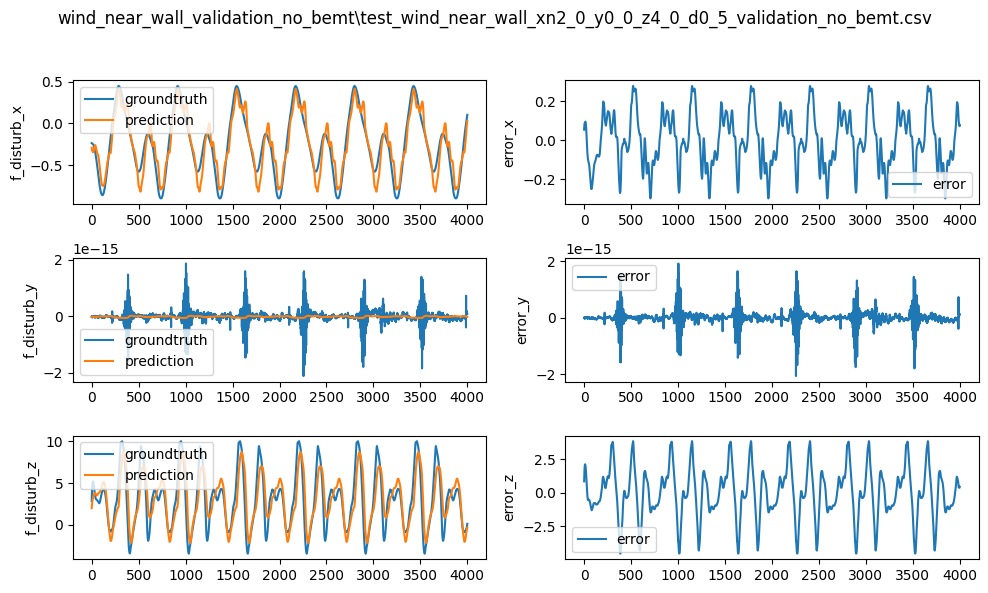

phi_out: tensor([[ 1.0000,  0.1288,  0.0154, -0.5026],
        [ 1.0000,  0.1358,  0.0058, -0.5272],
        [ 1.0000,  0.1425, -0.0150, -0.5602],
        ...,
        [ 1.0000,  0.0476,  0.1118, -0.2490],
        [ 1.0000,  0.0469,  0.1133, -0.2554],
        [ 1.0000,  0.0461,  0.1149, -0.2620]])
a = tensor([[ 6.7632e-01, -1.2964e-16,  4.3051e+00],
        [-1.0760e+01,  2.3488e-17,  4.8691e+00],
        [-7.3865e+00,  4.1066e-16, -4.2312e+00],
        [ 9.0346e-01, -1.9396e-16,  1.0210e+00]])


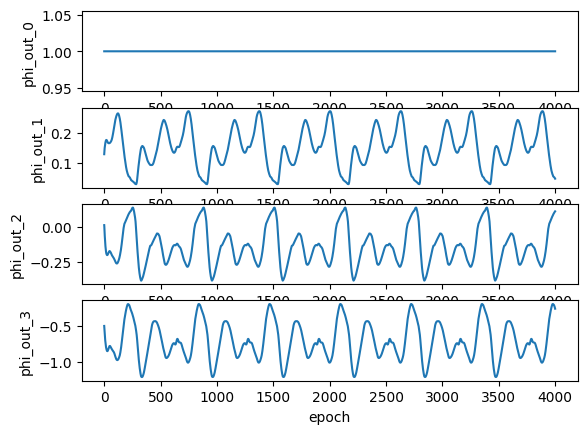

phi_out: tensor([[ 1.0000,  0.1279,  0.0171, -0.4988],
        [ 1.0000,  0.1288,  0.0171, -0.4993],
        [ 1.0000,  0.1295,  0.0171, -0.4992],
        ...,
        [ 1.0000,  0.0429,  0.1677, -0.2281],
        [ 1.0000,  0.0436,  0.1689, -0.2329],
        [ 1.0000,  0.0443,  0.1701, -0.2376]])
a = tensor([[-8.2675e-02, -5.4238e-17, -4.3465e+00],
        [-5.4384e+00,  4.8223e-17,  3.7740e+00],
        [-2.9997e-01,  1.0935e-16,  3.5488e+00],
        [-8.6709e-01, -5.6733e-17, -6.8662e+00]])


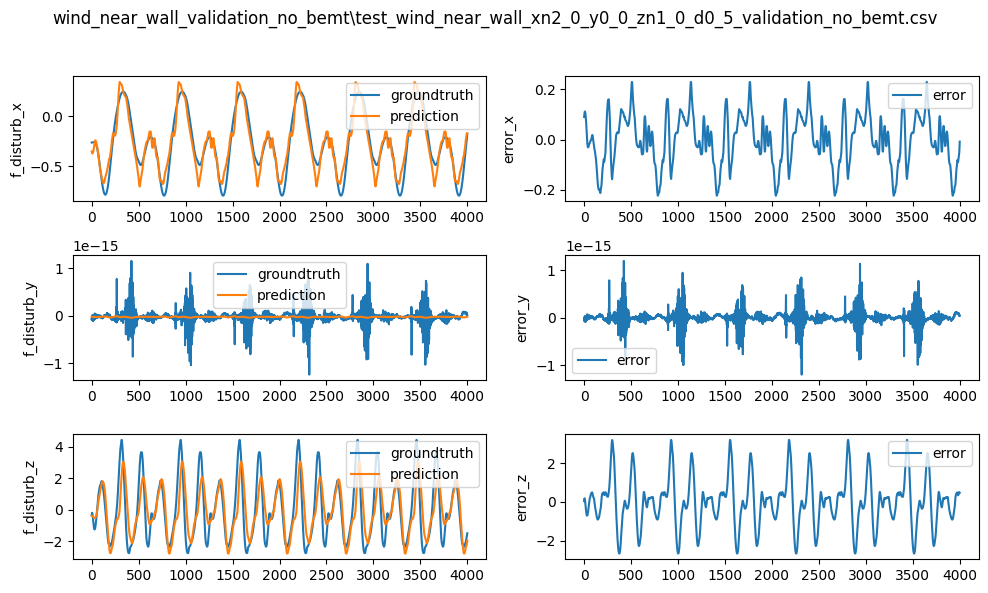

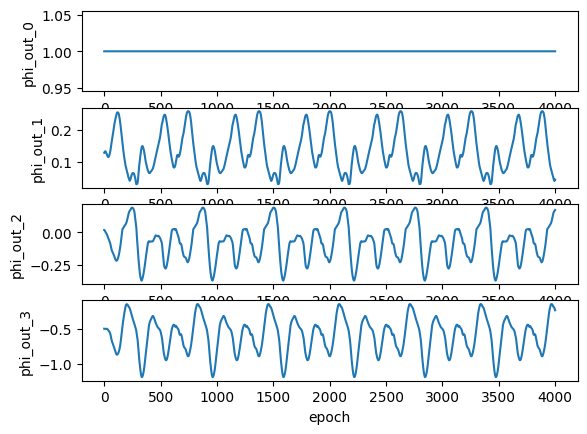

phi_out: tensor([[ 1.0000,  0.1280,  0.0170, -0.4991],
        [ 1.0000,  0.1295,  0.0164, -0.5013],
        [ 1.0000,  0.1309,  0.0154, -0.5033],
        ...,
        [ 1.0000,  0.0400,  0.1622, -0.2296],
        [ 1.0000,  0.0391,  0.1639, -0.2324],
        [ 1.0000,  0.0394,  0.1654, -0.2359]])
a = tensor([[ 2.8775e-02,  2.2311e-18, -2.1265e+00],
        [-7.3789e+00, -8.3431e-17,  3.0827e+00],
        [-1.5771e+00, -1.1352e-16,  1.3403e+00],
        [-8.0150e-01,  5.1923e-17, -3.4134e+00]])


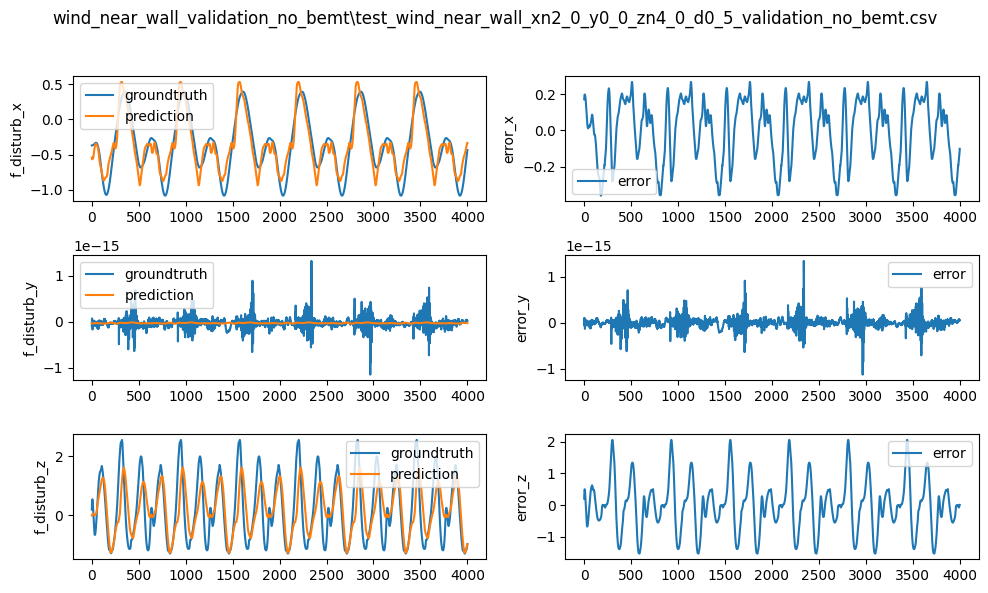

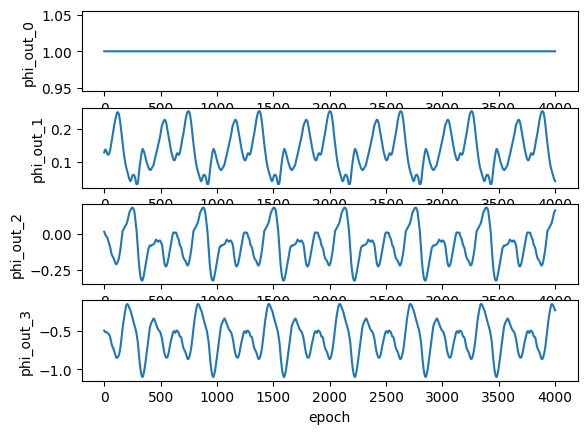

phi_out: tensor([[ 1.0000,  0.1284,  0.0162, -0.5012],
        [ 1.0000,  0.1340,  0.0098, -0.5157],
        [ 1.0000,  0.1385, -0.0019, -0.5318],
        ...,
        [ 1.0000,  0.0413,  0.1115, -0.1943],
        [ 1.0000,  0.0407,  0.1131, -0.1942],
        [ 1.0000,  0.0401,  0.1147, -0.1943]])
a = tensor([[-8.9151e-01, -1.2156e-16, -1.7294e+00],
        [-1.0803e+01, -2.9219e-16,  3.1524e-01],
        [ 2.1340e+00,  2.6766e-16,  4.3155e+00],
        [-2.4312e+00, -1.2832e-16, -1.0569e+01]])


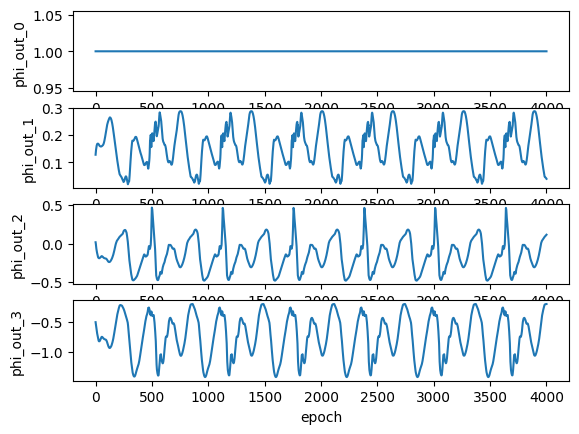

phi_out: tensor([[ 1.0000,  0.1281,  0.0169, -0.4996],
        [ 1.0000,  0.1308,  0.0153, -0.5042],
        [ 1.0000,  0.1333,  0.0115, -0.5097],
        ...,
        [ 1.0000,  0.0419,  0.1586, -0.2301],
        [ 1.0000,  0.0410,  0.1601, -0.2332],
        [ 1.0000,  0.0402,  0.1616, -0.2363]])
a = tensor([[-5.4533e-02, -5.5681e-17, -4.7612e+00],
        [-8.0104e+00, -3.3751e-16,  8.3325e+00],
        [-1.3682e+00,  1.2763e-18,  9.9417e+00],
        [-5.2878e-01, -6.4022e-17, -9.2318e+00]])


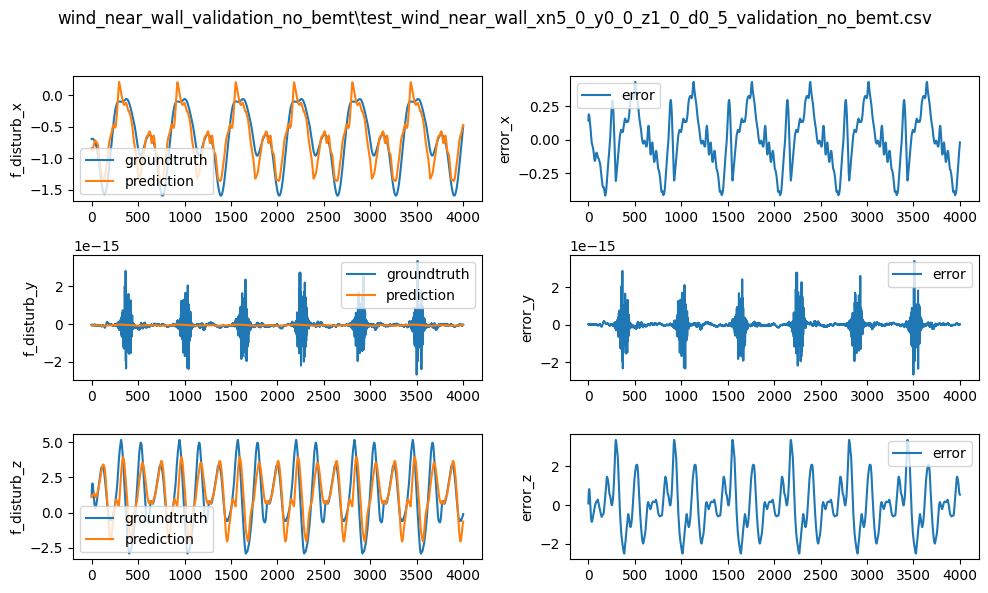

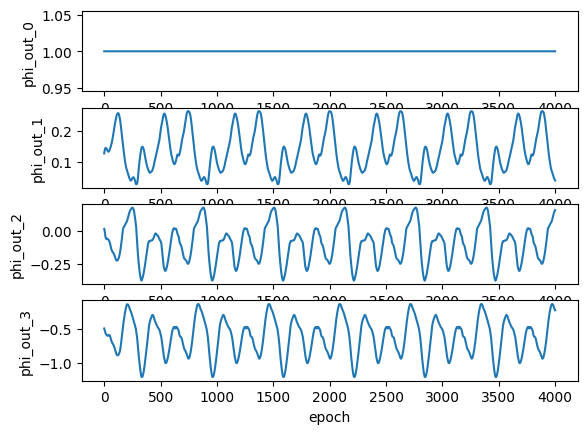

phi_out: tensor([[ 1.0000,  0.1283,  0.0166, -0.5003],
        [ 1.0000,  0.1325,  0.0128, -0.5096],
        [ 1.0000,  0.1363,  0.0068, -0.5196],
        ...,
        [ 1.0000,  0.0496,  0.1244, -0.2441],
        [ 1.0000,  0.0489,  0.1244, -0.2492],
        [ 1.0000,  0.0483,  0.1242, -0.2538]])
a = tensor([[-4.2188e-02,  4.7753e-17, -3.9069e+00],
        [-8.4137e+00,  1.2102e-16, -2.5106e+00],
        [-1.4364e+00, -4.1808e-16,  1.3561e+01],
        [-4.6476e-01,  2.8011e-16, -1.3668e+01]])


phi_out: tensor([[ 1.0000,  0.1286,  0.0159, -0.5021],
        [ 1.0000,  0.1358,  0.0066, -0.5217],
        [ 1.0000,  0.1414, -0.0131, -0.5455],
        ...,
        [ 1.0000,  0.0496,  0.1148, -0.2558],
        [ 1.0000,  0.0489,  0.1160, -0.2605],
        [ 1.0000,  0.0481,  0.1166, -0.2631]])
a = tensor([[ 7.0914e-01, -8.9689e-17,  4.3144e+00],
        [-1.3568e+01,  2.7789e-16,  6.0409e+00],
        [-1.0534e+01,  3.4970e-16, -6.7149e+00],
        [ 2.0490e+00,  2.8075e-17,  1.6996e+00]])


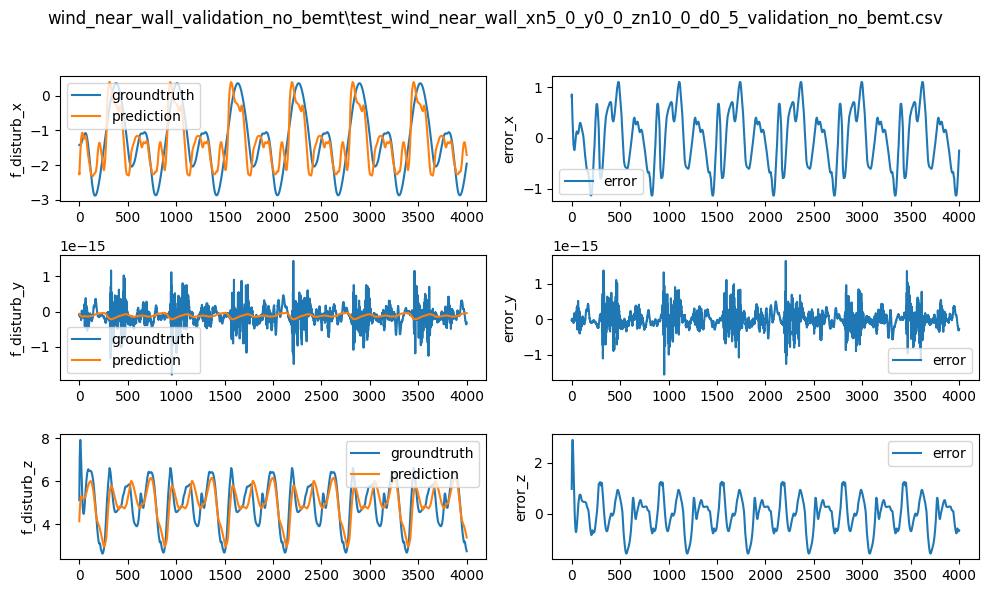

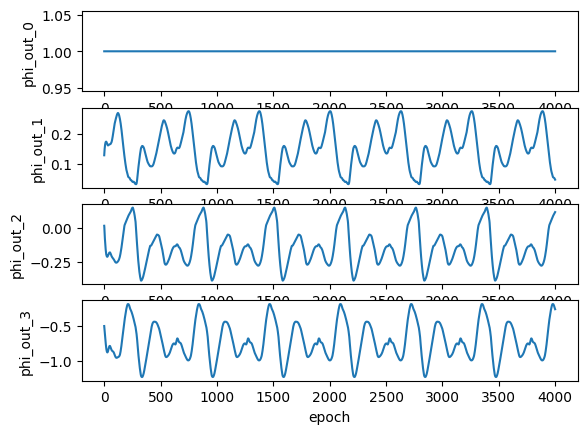

phi_out: tensor([[ 1.0000,  0.1279,  0.0172, -0.4989],
        [ 1.0000,  0.1295,  0.0175, -0.4986],
        [ 1.0000,  0.1310,  0.0156, -0.4999],
        ...,
        [ 1.0000,  0.0421,  0.1604, -0.2333],
        [ 1.0000,  0.0414,  0.1618, -0.2364],
        [ 1.0000,  0.0406,  0.1632, -0.2395]])
a = tensor([[-5.4081e-02, -5.9234e-17, -4.5512e+00],
        [-7.9110e+00, -1.9602e-16,  7.0436e+00],
        [-1.9058e+00,  1.8075e-17,  7.7433e+00],
        [-3.9760e-01, -3.3836e-17, -7.6690e+00]])


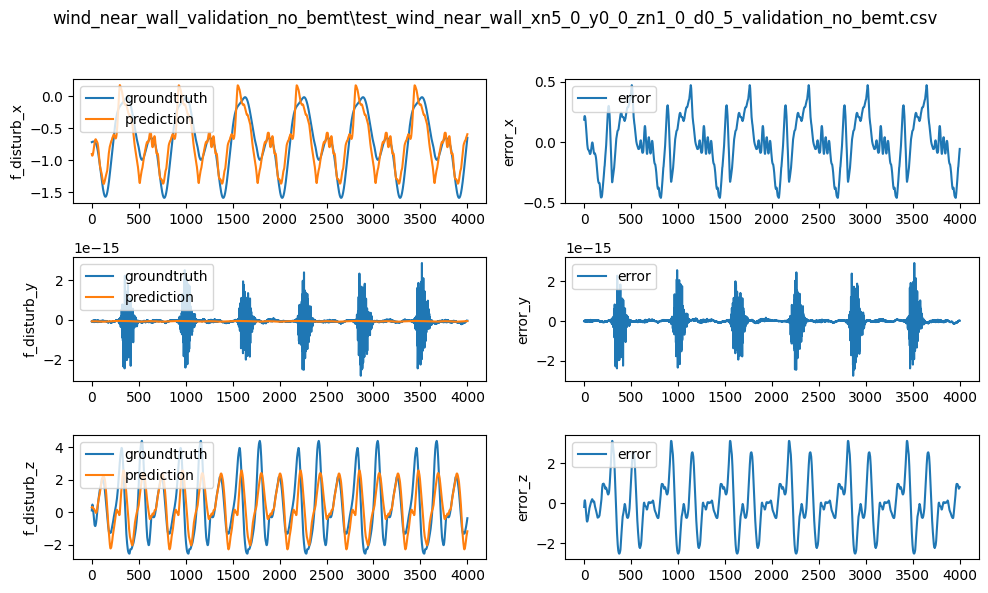

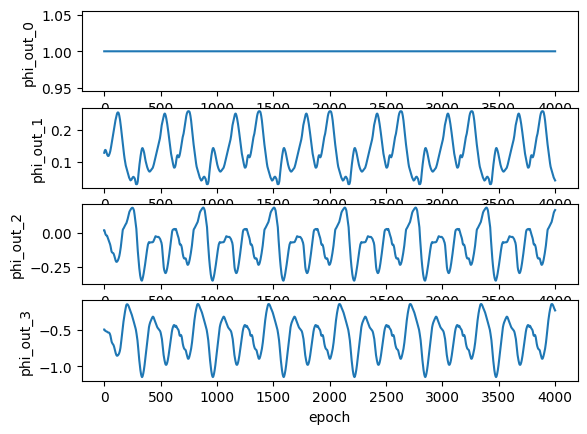

phi_out: tensor([[ 1.0000,  0.1279,  0.0173, -0.4988],
        [ 1.0000,  0.1298,  0.0176, -0.4977],
        [ 1.0000,  0.1316,  0.0138, -0.5007],
        ...,
        [ 1.0000,  0.0420,  0.1633, -0.2355],
        [ 1.0000,  0.0415,  0.1649, -0.2385],
        [ 1.0000,  0.0418,  0.1665, -0.2421]])
a = tensor([[-5.1790e-03, -6.7258e-17, -2.2237e+00],
        [-9.7277e+00,  2.3564e-17,  4.6928e+00],
        [-3.2000e+00,  3.5376e-17,  1.2856e+00],
        [-2.9485e-01,  3.2679e-17, -3.3947e+00]])


average rms for dim 0: 0.24887801483610555
average rms for dim 1: 2.0405625627802664e-16
average rms for dim 2: 1.2960636367534906


c:\YimingVirtualDDrive\7_workSpace\repo\neural-fly\Simulation\learning\validator.py:143: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


average mse for dim 0: 0.0867559674078322
average mse for dim 1: 5.302262205750588e-32
average mse for dim 2: 1.9059042365462584


c:\YimingVirtualDDrive\7_workSpace\repo\neural-fly\Simulation\learning\validator.py:169: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


In [6]:
%matplotlib inline
model_name = training_subfolder

# subfolder = "wind_near_wall_validation_bemt"
subfolder = "wind_near_wall_validation_no_bemt"
# subfolder = "nf_validation_back2back"
data_list = generate_data_list(subfolder)
print("test Data List:")
for data in data_list:
    print(data)

# debug
# data_list = data_list[:1]  # use small data list for quick testing

manager = training_manager.TestManager()
manager.set_up(
    data_menu=data_list,
    input_label_map_file=path1,
    column_map_file=path2,
    can_skip_io_normalizaiton=False
)

phi, h = training_manager.load_model(model_name)
# make a new trainer to replicate the above setup, just to allow verify_model to work
manager.test(phi, h, data_list)
plt.show()  
